In [1]:
# import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 



import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator


# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc


from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

In [2]:
!python src/run.py data/sample_sub1.csv

python: can't open file 'src/run.py': [Errno 2] No such file or directory


In [3]:
movies = pd.read_csv('data/movies.dat', sep='\t|::',header=None, engine='python')
users = pd.read_csv('data/users.dat', sep='\t|::',header=None, engine='python')
ratings = pd.read_csv('data/training.csv')

In [7]:
def load_data_to_spark():
    schema = StructType([
        StructField("user", IntegerType(), True),
        StructField("movie", IntegerType(), True),
        StructField("rating", IntegerType(), True)])
    df = pd.read_csv('data/training.csv')
    df = df.drop(columns='timestamp')
    s_df = spark.createDataFrame(df, schema=schema)
    return s_df, df

In [8]:
s_df, p_df = load_data_to_spark()

In [170]:
movies.set_index(0).loc[1210]

1    Star Wars: Episode VI - Return of the Jedi (1983)
2                  Action|Adventure|Romance|Sci-Fi|War
Name: 1210, dtype: object

In [133]:
movies = pd.read_csv('data/movies.dat', sep='\t|::',header=None, engine='python')
movies[2].map(lambda genres: genres.split('|'))

0        [Animation, Children's, Comedy]
1       [Adventure, Children's, Fantasy]
2                      [Comedy, Romance]
3                        [Comedy, Drama]
4                               [Comedy]
                      ...               
3878                            [Comedy]
3879                             [Drama]
3880                             [Drama]
3881                             [Drama]
3882                   [Drama, Thriller]
Name: 2, Length: 3883, dtype: object

In [10]:
train, test = s_df.randomSplit([0.8, 0.2], seed=427471138)

In [188]:
ratings.rating.mean()

3.59047875

In [21]:
ratings['movie'][ratings['timestamp']==ratings.groupby('user')['timestamp'].max()]

ValueError: Can only compare identically-labeled Series objects

### Movie Seen First

In [27]:
time_first_movie = ratings.groupby('user')['timestamp'].min()

In [48]:
movies_first = {}
for user in time_first_movie.index:
    movie = ratings[
        (ratings.user == user) & 
        (ratings.timestamp == time_first_movie[user])
    ]['movie']
    if len(movie)> 1:
        for m in movie:
            if m in movies_first:
                movies_first[m] += 1
            else:
                movies_first[m] = 1
    else:
        if m in movies_first:
            movies_first[m] += 1
        else:
            movies_first[m] = 1

In [49]:
time_first_movie[636]

975751854

In [135]:
len(movies_first)

2477

In [64]:
movies_first_df = pd.Series(movies_first.values(), index=movies_first.keys())

In [65]:
movies_first_df.values

array([  3, 114,  86, ...,   1,   3,   1])

<BarContainer object of 153 artists>

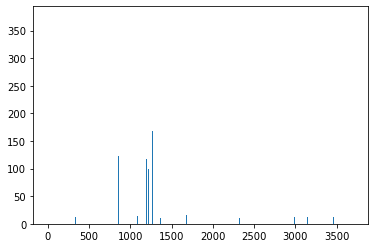

In [67]:
fig, ax = plt.subplots()

ax.bar(movies_first_df[movies_first_df>10].index, movies_first_df[movies_first_df>10].values)

In [72]:
movies_first_df.argsort().values

array([1238, 1662, 1661, ...,   20,   43,    5])

In [87]:
movies_seen_first = movies_first_df.iloc[movies_first_df.argsort().values][-1:-11:-1].index

In [95]:
ratings.groupby('movie')['rating'].mean()[movies_seen_first]

1210    4.019544
1193    4.399580
1270    3.983509
260     4.452087
527     4.502585
1961    4.048803
1198    4.478673
1968    3.890736
1196    4.290143
2028    4.326503
Name: rating, dtype: float64

In [185]:
first = movies_first_df[movies_first_df<50].values

In [186]:
first_rating = ratings.groupby('movie')['rating'].mean()[movies_first_df[movies_first_df<50].index].values

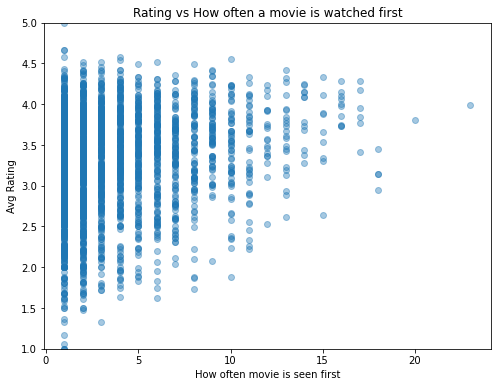

In [187]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(first, first_rating, alpha=.4)
ax.set_xlabel('How often movie is seen first')
ax.set_ylabel('Avg Rating')
ax.set_title('Rating vs How often a movie is watched first')
ax.set_ylim(1,5)
plt.savefig('img/seen_first_rating_minus50.png')

In [167]:
movies_first_df[movies_first_df>300]

1210    375
dtype: int64

### Popularity

In [118]:
most_viewed = ratings.groupby('movie')['user'].count().argsort()[-1:-11:-1]

In [119]:
ratings.groupby('movie')['user'].count().iloc[most_viewed]

movie
2858    2901
1196    2516
260     2515
1210    2456
589     2284
2028    2245
480     2232
1270    2183
2571    2172
1580    2156
Name: user, dtype: int64

In [122]:
most_viewed.values

array([2620, 1089,  253, 1103,  569, 1823,  463, 1161, 2345, 1428])

In [123]:
ratings.groupby('movie')['rating'].mean()[most_viewed.values]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([1823], dtype='int64', name='movie'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

Plot popularity vs rating

In [128]:
popularity = ratings.groupby('movie')['user'].count().values

In [129]:
avg_rating = ratings.groupby('movie')['rating'].mean().values

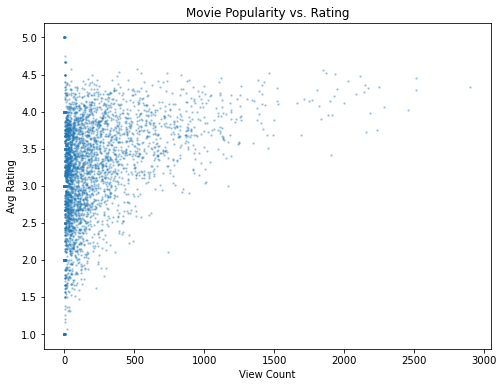

In [175]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(popularity, avg_rating, alpha=.3, s=2)
ax.set_title('Movie Popularity vs. Rating')
ax.set_ylabel('Avg Rating')
ax.set_xlabel('View Count')
plt.savefig('img/popularity_rating.png')